In [18]:
# !pip install xgboost

In [ ]:
# ============================================
# 1) LOAD DATA
# ============================================
DELTA_GOLD = "../EDA/Deltas/Delta_gold2"

import pandas as pd
import numpy as np
from deltalake import DeltaTable

from sklearn.metrics import f1_score, recall_score, precision_score

df = DeltaTable(DELTA_GOLD).to_pandas()

df["date"] = pd.date_range(start="2020-01-01", periods=len(df), freq="H")
df['date'] = pd.to_datetime(df['date'])

# ============================================
# 2) FEATURES
# ============================================
feature_columns = [
    "temperature_max",
    "wind_speed_max",
    "precipitation_total",
    "relative_humidity",
    "soil_moisture",
    "evapotranspiration",
    "shortwave_radiation",
    "day_of_year",
    "day_of_week",
    "is_weekend",
    "longitude",
    "latitude",
    "sea_distance"
]

label_col = "is_fire"
SPLIT_DATE = "2022-01-01"

# TIME-SPLIT
train_df = df[df["date"] < SPLIT_DATE].copy()
test_df = df[df["date"] >= SPLIT_DATE].copy()

# ============================================
# 3) IMPUTATION
# ============================================
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train_full = pd.DataFrame(imputer.fit_transform(train_df[feature_columns]), columns=feature_columns)
X_test = pd.DataFrame(imputer.transform(test_df[feature_columns]), columns=feature_columns)

y_train_full = train_df[label_col].astype(int)
y_test = test_df[label_col].astype(int)

# ============================================
# 4) TIME-SPLIT
# ============================================
split_idx = int(len(train_df) * 0.8)

X_train = X_train_full.iloc[:split_idx]
y_train = y_train_full.iloc[:split_idx]

X_valid = X_train_full.iloc[split_idx:]
y_valid = y_train_full.iloc[split_idx:]

# ============================================
# 5) XGBOOST TRAINING
# ============================================
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    learning_rate=0.03,
    max_depth=8,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
)

print("Training XGBoost...")

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=50
)

print("Training complete.")

# ============================================
# 6) PREDICTIONS + THRESHOLD OPTIMIZATION
# ============================================
y_prob = xgb_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.02)

best_f1 = 0
best_t = 0.5

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("\nBest threshold:", best_t)
print("Best F1:", best_f1)

y_pred = (y_prob >= best_t).astype(int)


C:\Users\dell\AppData\Local\Temp\ipykernel_9692\1915673988.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["date"] = pd.date_range(start="2020-01-01", periods=len(df), freq="H")


Training XGBoost...
[0]	validation_0-auc:0.87824
[50]	validation_0-auc:0.90725
[100]	validation_0-auc:0.90749
[150]	validation_0-auc:0.90701
[200]	validation_0-auc:0.90627
[250]	validation_0-auc:0.90562
[300]	validation_0-auc:0.90515
[350]	validation_0-auc:0.90454
[400]	validation_0-auc:0.90370
[450]	validation_0-auc:0.90301
[499]	validation_0-auc:0.90259
Training complete.

Best threshold: 0.3400000000000001
Best F1: 0.7638579478443193



=== XGBOOST METRICS ===
Accuracy: 0.8241196220816741
Precision: 0.7066996435585946
Recall: 0.8310758789814366
F1: 0.7638579478443193
ROC AUC: 0.9059800160697973
PR AUC: 0.8268657308099416

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     67387
           1       0.71      0.83      0.76     35069

    accuracy                           0.82    102456
   macro avg       0.80      0.83      0.81    102456
weighted avg       0.84      0.82      0.83    102456



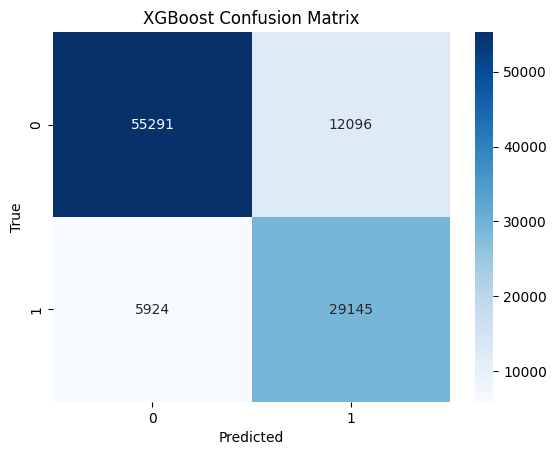


=== FEATURE IMPORTANCE ===
                Feature  Importance
0       temperature_max    0.313010
3     relative_humidity    0.128881
1        wind_speed_max    0.081578
12         sea_distance    0.080104
7           day_of_year    0.079566
6   shortwave_radiation    0.050832
4         soil_moisture    0.044068
2   precipitation_total    0.041944
5    evapotranspiration    0.041447
11             latitude    0.036323
9            is_weekend    0.035572
10            longitude    0.034851
8           day_of_week    0.031823


In [6]:
# ============================================
# 7) EVALUATION
# ============================================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix
)

print("\n=== XGBOOST METRICS ===")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("PR AUC:", average_precision_score(y_test, y_prob))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# ============================================
# 8) CONFUSION MATRIX
# ============================================
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# ============================================
# 9) FEATURE IMPORTANCE
# ============================================
importances = xgb_model.feature_importances_
feature_names = X_train.columns

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print("\n=== FEATURE IMPORTANCE ===")
print(fi_df)


In [7]:
import pandas as pd

def test_sample(sample):
    df = pd.DataFrame([sample])
    prediction = xgb_model.predict(df)[0]
    print("🔥 Predicted fire risk:", prediction)
    return prediction



In [12]:
results = X_test.copy()
results['date'] = df.loc[X_test.index, 'date']
results['True Label'] = y_test
results['Predicted Probability'] = y_prob
results['Predicted Label'] = y_pred

print("\n--- Sample Predictions ---")
results.head(10)


--- Sample Predictions ---


,temperature_max,wind_speed_max,precipitation_total,relative_humidity,soil_moisture,evapotranspiration,shortwave_radiation,day_of_year,day_of_week,is_weekend,longitude,latitude,sea_distance,date,True Label,Predicted Probability,Predicted Label
0,20.560677,41.803054,2.079524,77.565152,0.077843,1.922368,275.831242,203.0,2.0,0.0,-10.310707,28.598491,169.616547,2020-01-01 00:00:00,NaN,0.259603,0
1,26.960932,39.001292,0.327759,62.897575,0.000000,3.939121,339.691436,248.0,6.0,1.0,-7.107023,22.080310,300.000000,2020-01-01 01:00:00,NaN,0.798725,1
2,23.371128,40.895770,4.607677,79.021758,0.022772,3.004538,192.753128,181.0,0.0,0.0,-1.036553,30.777004,300.000000,2020-01-01 02:00:00,NaN,0.212281,0
3,29.384927,37.898319,2.449696,66.023445,0.047816,2.877480,345.705098,275.0,1.0,0.0,-2.429513,33.680091,216.205495,2020-01-01 03:00:00,NaN,0.417451,1
4,22.960406,48.642171,5.814850,75.718648,0.068593,2.091223,221.888678,30.0,2.0,0.0,-1.112007,34.477721,266.807591,2020-01-01 04:00:00,NaN,0.050523,0
5,29.085824,39.974313,4.147674,62.330514,0.024350,3.722464,256.813029,247.0,6.0,1.0,-11.481251,24.394918,300.000000,2020-01-01 05:00:00,NaN,0.786453,1
6,20.377308,34.286695,15.787509,70.995817,0.190865,2.285024,168.254266,25.0,1.0,0.0,-7.629185,30.831320,194.595999,2020-01-01 06:00:00,NaN,0.003310,0
7,17.973173,55.607347,4.558012,89.916628,0.040344,2.571180,139.537438,66.0,4.0,0.0,-6.367223,21.185082,300.000000,2020-01-01 07:00:00,NaN,0.154544,0
8,20.962120,39.891293,3.796508,82.400162,0.049879,1.694821,237.414551,185.0,2.0,0.0,-6.532772,30.657847,295.166241,2020-01-01 08:00:00,NaN,0.073814,0
9,18.368709,46.027037,1.241967,80.628465,0.017923,1.679321,159.428266,164.0,5.0,1.0,-8.025319,32.530340,125.370104,2020-01-01 09:00:00,NaN,0.052576,0



GENERATING 6-PANEL XGBOOST EVALUATION MAP


C:\Users\dell\AppData\Local\Temp\ipykernel_9692\2939154764.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\dell\AppData\Local\Temp\ipykernel_9692\2939154764.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


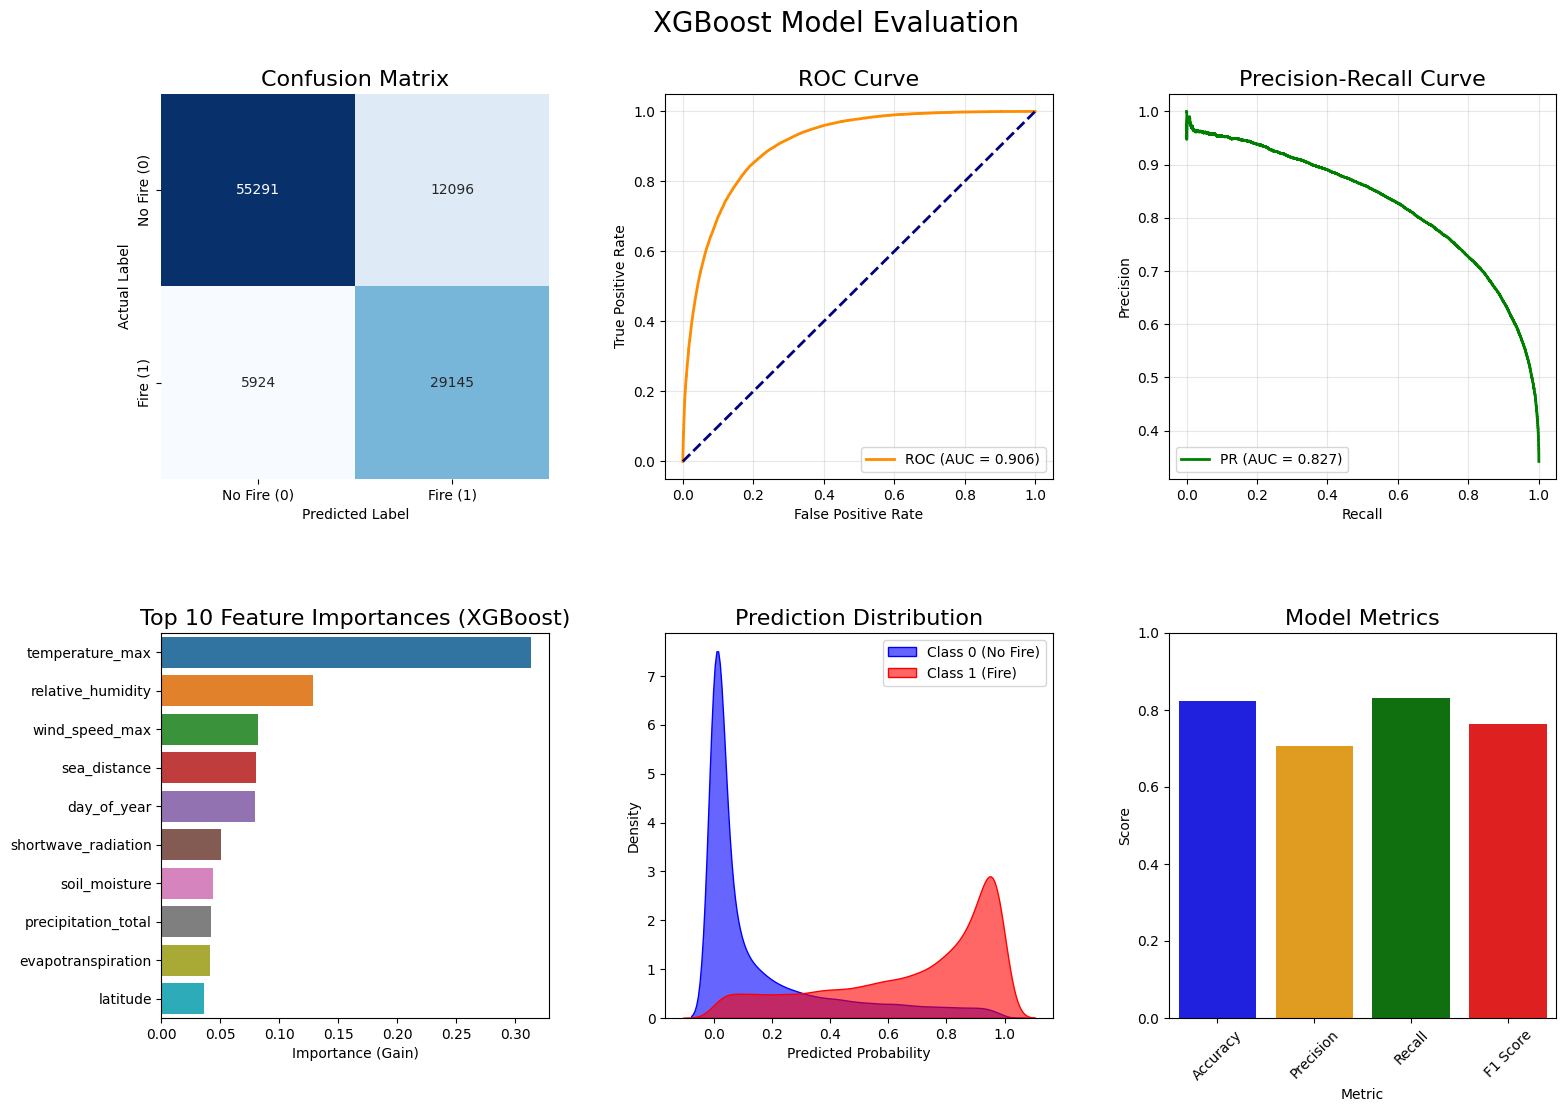

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)



y_test_final = y_test
y_pred_final = y_pred
y_prob_final = y_prob
feature_names = X_train.columns

importances = xgb_model.feature_importances_

# -----------------
# METRICS DICT
# -----------------
metrics_dict = {
    'Accuracy': accuracy_score(y_test_final, y_pred_final),
    'Precision': precision_score(y_test_final, y_pred_final),
    'Recall': recall_score(y_test_final, y_pred_final),
    'F1 Score': f1_score(y_test_final, y_pred_final),
    'ROC AUC': roc_auc_score(y_test_final, y_prob_final),
    'PR AUC': average_precision_score(y_test_final, y_prob_final),
}

# -----------------
# FIGURE
# -----------------
print("\n" + "="*50)
print("GENERATING 6-PANEL XGBOOST EVALUATION MAP")
print("="*50)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.suptitle('XGBoost Model Evaluation', fontsize=20, y=0.95)

# =====================================================
# 1. CONFUSION MATRIX
# =====================================================
cm = confusion_matrix(y_test_final, y_pred_final)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
    cbar=False,
    xticklabels=["No Fire (0)", "Fire (1)"],
    yticklabels=["No Fire (0)", "Fire (1)"]
)
axes[0, 0].set_title('Confusion Matrix', fontsize=16)
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_ylabel('Actual Label')

# =====================================================
# 2. ROC CURVE
# =====================================================
fpr, tpr, _ = roc_curve(y_test_final, y_prob_final)
roc_auc = metrics_dict['ROC AUC']
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC (AUC = {roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve', fontsize=16)
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(True, alpha=0.3)

# =====================================================
# 3. PRECISION-RECALL CURVE
# =====================================================
precision, recall, _ = precision_recall_curve(y_test_final, y_prob_final)
pr_auc = metrics_dict['PR AUC']
axes[0, 2].plot(recall, precision, color='green', lw=2,
                label=f'PR (AUC = {pr_auc:.3f})')
axes[0, 2].set_xlabel('Recall')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].set_title('Precision-Recall Curve', fontsize=16)
axes[0, 2].legend(loc="lower left")
axes[0, 2].grid(True, alpha=0.3)

# =====================================================
# 4. TOP 10 FEATURE IMPORTANCES
# =====================================================
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False).head(10)

sns.barplot(
    x="Importance", y="Feature", data=fi_df,
    ax=axes[1, 0], palette="tab10"
)
axes[1, 0].set_title('Top 10 Feature Importances (XGBoost)', fontsize=16)
axes[1, 0].set_xlabel('Importance (Gain)')
axes[1, 0].set_ylabel('')

# =====================================================
# 5. PREDICTION DISTRIBUTION
# =====================================================
sns.kdeplot(
    y_prob_final[y_test_final == 0],
    label='Class 0 (No Fire)', color='blue',
    ax=axes[1, 1], fill=True, alpha=0.6
)
sns.kdeplot(
    y_prob_final[y_test_final == 1],
    label='Class 1 (Fire)', color='red',
    ax=axes[1, 1], fill=True, alpha=0.6
)
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Prediction Distribution', fontsize=16)
axes[1, 1].legend()

# =====================================================
# 6. MODEL METRICS BAR PLOT
# =====================================================
metrics_df = pd.DataFrame(
    list(metrics_dict.items()),
    columns=['Metric', 'Value']
)

sns.barplot(
    x='Metric', y='Value',
    data=metrics_df.drop(index=[4, 5]),
    ax=axes[1, 2],
    palette=['blue', 'orange', 'green', 'red']
)
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Model Metrics', fontsize=16)
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].set_ylim(0, 1)

plt.show()
